# Existing Model Accuracy

In this document, I explore the accuracies of various models that predict virus-host interactions solely from DNA sequences.

To date (07/07/2022), I ran VirHostMatcher-Net, vHULK, CHERRY and RaFAH. I will explore the outputs of each oef those tools one a time. In addition, the input data used can be divided into 3 datasets:
1. NCBI phages, which is a mix between collected host range from literature and interactions extracted from GenBank files
2. Nahant Collection, a complete host range set between phages and Vibrio species
3. Staph Study, also a complete host range set between phages and Staph species from different environments.

When calculating the accuracy of the aforementioned tools, due to their approach in making the predictions (that is, predicting taxa rather than interaction), there will be 3 possibilities:
1. The prediction is correct (predicted host = known host)
2. The prediction is false (predicted host = known non-infection)
3. Cannot determine if the prediction is correct or incorrect (the pair was not tested in the lab)


## Setup

First, let's load modules.

In [1]:
import os
print(os.getcwd())

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO


/Users/gbastien/Documents/Research/Projects/ExistingVHPModels/analysis


### Metadata

I also need to load some various metadata tables. For instance, depending on the tool, the naming system used to keep track of which virus infect which host may be different (using filenames versus accession number for example).

Below I load metadata tables that I will be using throughout the document.


In [2]:
StaphStudy_virusnames = pd.read_csv('../data/other/StaphStudy_virusnames.tsv', sep='\t')

# Add new column to contain the GCA filename of phage (only the GCA and numbers and nothing after it)
filenames = StaphStudy_virusnames['filename'].tolist()
GCAid = []
for name in filenames:
    GCAid.append(name.split('.')[0])
StaphStudy_virusnames['phageGCAid'] = GCAid

StaphStudy_virusnames

,Unnamed: 0,filename,accession,phagename,phageGCAid
0,0,GCA_021090665.1_ASM2109066v1_genomic.fna,MZ417315.1,PG-2021_10,GCA_021090665
1,1,GCA_021090675.1_ASM2109067v1_genomic.fna,MZ417316.1,PG-2021_12,GCA_021090675
2,2,GCA_021090685.1_ASM2109068v1_genomic.fna,MZ417317.1,PG-2021_14,GCA_021090685
3,3,GCA_021090695.1_ASM2109069v1_genomic.fna,MZ417318.1,PG-2021_15,GCA_021090695
4,4,GCA_021090705.1_ASM2109070v1_genomic.fna,MZ417319.1,PG-2021_16,GCA_021090705
5,5,GCA_021090715.1_ASM2109071v1_genomic.fna,MZ417320.1,PG-2021_17,GCA_021090715
6,6,GCA_021090725.1_ASM2109072v1_genomic.fna,MZ417321.1,PG-2021_18,GCA_021090725
7,7,GCA_021090735.1_ASM2109073v1_genomic.fna,MZ417322.1,PG-2021_19,GCA_021090735
8,8,GCA_021090745.1_ASM2109074v1_genomic.fna,MZ417323.1,PG-2021_1,GCA_021090745
9,9,GCA_021090755.1_ASM2109075v1_genomic.fna,MZ417324.1,PG-2021_22,GCA_021090755


In [3]:
# list sequence files
datadir = '../data/sequences/phages/NahantCollection/'
files = os.listdir(datadir)

MGid = []
GCAid = []

# iterate through each file and get record id
for file in files:
    if file.endswith('.fasta'):
        GCAid.append(file.split('.')[0])
        loc = datadir + file
        for record in SeqIO.parse(loc, 'fasta'):
            MGid.append(record.id)

# make dataframe
NahantCollection_virusnames = pd.DataFrame()
NahantCollection_virusnames['MGid'] = MGid
NahantCollection_virusnames['GCAid'] = GCAid

NahantCollection_virusnames

,MGid,GCAid
0,MG592461.1,GCA_003927395
1,MG592607.1,GCA_003930195
2,MG592555.1,GCA_003929195
3,MG592500.1,GCA_003928155
4,MG592496.1,GCA_003928075
...,...,...
278,MG592542.1,GCA_003928955
279,MG592538.1,GCA_003928875
280,MG592597.1,GCA_003929995
281,MG592647.1,GCA_003930995


### Taxonomy

Lastly, I need to load the taxonomy file for bacteria and archaea, which will be needed to determine the accuracy of the tools at different taxa level.

In [4]:
taxa = pd.read_csv('../data/other/bacteria_archaea_taxonomy.csv')
taxa

,Genus_species,Domain,Phylum,Class,Order,Family,Genus
0,Acaryochloris_marina,Bacteria,Cyanobacteria,Cyanobacteria,Synechococcales,Acaryochloridaceae,Acaryochloris
1,Acetobacter_aceti,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirrllales,Acetobacteraceae,Acetobacter
2,Acetobacter_ascendens,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirrllales,Acetobacteraceae,Acetobacter
3,Acetobacter_orientalis,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirrllales,Acetobacteraceae,Acetobacter
4,Acetobacter_oryzifermentans,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirrllales,Acetobacteraceae,Acetobacter
...,...,...,...,...,...,...,...
3278,Salinivibrio_costicola,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Salinivibrio
3279,Enterovibrio_norvegicus,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Enterovibrio
3280,Phormidium_foveolarum,Bacteria,Cyanobacteria,Cyanobacteria,Pseudanabaenales,Leptolyingbyaceae,Phormidium
3281,Faecalibacterium_prausnitzii,Bacteria,Bacillota,Clostridia,Eubacteriales,Oscillosipiraceae,Faecalibacterium


### Host Range Only

I also need to extract only host range data. Currently, my NCBI data is a mix between host range data collected from literature, and host range extracted from virus GenBank files. The issue is that host range retrieved from virus GenBank files is the predominant data that was used to create the models that I am testing in this document. So the value of checking models' accuracies on data that was used to train the model is simply none.

So in the following code chunk, I am extracting host range data that was solely collected from literature, rather than virus GenBank files!

The best way to approach it to consider all viruses in the NCBI database. Then remove from the NCBI database any pair that are in the virus GenBank files.

First, I am going to load all the host range data. This also include the Nahant Collection and the Staph Study.


In [5]:
# all host range data
allHR = pd.read_csv('../data/hostrange/allhostrange.csv')

# add taxa levels information
Genus = []
Family = []
Order = []
Class = []
Phylum = []
Domain = []

for _, rows in allHR.iterrows():
    genus_species = rows['hostname']
    genus = genus_species.replace('_', ' ').split(' ')[0]
    Genus.append(genus)

    subset = taxa[taxa['Genus'] == genus]

    Family.append(subset['Family'].values[0])
    Order.append(subset['Order'].values[0])
    Class.append(subset['Class'].values[0])
    Phylum.append(subset['Phylum'].values[0])
    Domain.append(subset['Domain'].values[0])

allHR['genus'] = Genus
allHR['family'] = Family
allHR['order'] = Order
allHR['class'] = Class
allHR['phylum'] = Phylum
allHR['domain'] = Domain

# subset allHR to retrieve NCBI host range, Nahant Collection, and Staph Study
NCBIHR = allHR[allHR['data'] == 'NCBI_HR']
NahantCollectionHR = allHR[allHR['data'] == 'NahantCollection']
StaphStudyHR = allHR[allHR['data'] == 'StaphStudy']

So now I have the host range for each dataset. Now I am going to focus on formatting the NCBIHR so I only have host range from literature instead of GenBank files. In the past, I parsed the phage GenBank file so I am going to use that table. The resulting dataframe is named LiteratureHR.

In [6]:
# read parsed GB file
parsed_phageGB = pd.read_csv('../data/GenBank/NCBIphages_parsedGB.csv')

# initialize two lists
phagelist = []
hostlist = []

# iterate through the parsed_phageGB
for _, row in parsed_phageGB.iterrows():
    # get phage info
    phage = row['accession']
    # get phage's host info
    temp = row['host'].split(' ')
    if len(temp) < 2:
        continue
    host = temp[0] + '_' + temp[1]
    # store phage and host in respective list
    phagelist.append(phage)
    hostlist.append(host)

# create dataframe
toremove = {phagelist[i]: hostlist[i] for i in range(len(phagelist))}

# copy NCBI hr, then remove undesired pairs -- the ones extracted from GenBank files
LiteratureHR = NCBIHR.copy()
todrop = []
for index, row in LiteratureHR.iterrows():
    # check if phage and pair exist in dictionary. if it does, add index that will need to be removed
    phage = row['phagename']
    host = row['hostname']
    if phage in toremove:
        if host in toremove[phage]:
            todrop.append(index)

LiteratureHR.drop(todrop, inplace=True)

Let's see the resulting size of each of the dataframes!

In [7]:
print(f'Number of rows in NCBIHR is {NCBIHR.shape[0]}')
print(f'Number of rows in LiteratureHR is {LiteratureHR.shape[0]}')
print(f'Number of rows in NahantCollectionHR is {NahantCollectionHR.shape[0]}')
print(f'Number of rows in StaphStudyHR is {StaphStudyHR.shape[0]}')


Number of rows in NCBIHR is 2588
Number of rows in LiteratureHR is 552
Number of rows in NahantCollectionHR is 5208
Number of rows in StaphStudyHR is 1053


## Functions

All my functions to automate some coding will be here

## Assessing virus-host predictions tools

Before I start to determine the accuracy of each tool, I am going to create an empty dataframe to store the results. I will use this dataframe to plot the results!

In [8]:
# initialize dataframe
results = pd.DataFrame(columns=['Tool', 'Dataset', 'Taxa_lvl', 'Correct', 'Wrong', 'Unknown'])



### VirHostMatcher-Net

I am going to explore the accuracies of VirHostMatcher-Net. The output for VirHostMatcher-Net is a single file per prediction. So each phage will have their own individual prediction. The other interesting part of VirHostMatcher-Net is that it also return multiple potential hosts ranked from most likely to less likely. This will allow the following question: did VHM-net successfully predict the host after x amount of prediction? It's something to keep in mind for later, though for now I will just focus on the best prediction!


#### Staph Study

Let's start with the Staph Study, being the smallest dataset.

When looking at one of the prediction file, the phage name is not included, but it is present in the filename.

Below, I am formatting the resulting predictions!


In [9]:
# make a list of files
datadir = '../data/predictions/VirHostMatcher-Net/StaphStudy_predictions/predictions/'
files = os.listdir(datadir)

# initialize dataframe
VHMnet_StaphStudy_preds = pd.DataFrame()

# load and stitch the files together
for file in files:
    # location of file
    loc = datadir + file
    # read file, extract phage name, add new column, store file in VHMnet_StaphStudy_preds
    df = pd.read_csv(loc)
    phage = file.split('.')[0]
    df['phagename'] = phage

    if VHMnet_StaphStudy_preds.empty:
        VHMnet_StaphStudy_preds = df
    else:
        VHMnet_StaphStudy_preds = pd.concat([VHMnet_StaphStudy_preds, df])

# reformat the hostname column to fit the format that I have in the host range
hostnames = VHMnet_StaphStudy_preds['hostSpecies'].tolist()
newnames = []
for name in hostnames:
    temp = name.split(' ')
    string = temp[0] + '_' + temp[1]
    newnames.append(string)
VHMnet_StaphStudy_preds['hostSpecies'] = newnames

phagenames = VHMnet_StaphStudy_preds['phagename']
phagePGid = []
for name in phagenames:
    PGid = StaphStudy_virusnames.loc[StaphStudy_virusnames['phageGCAid'] == name, 'phagename'].values[0]
    phagePGid.append(PGid)
VHMnet_StaphStudy_preds['phagePGid'] = phagePGid

# retrieve best predictions
VHMnet_StaphStudy_bestpreds = VHMnet_StaphStudy_preds.iloc[::10, :]

With the data stiched and formatted correctly, I can now calculate the accuracy of the tool at predicting hosts from the Staph Study host range, and I can also determine the accuracy at different taxa level!

First, I will calculate the accuracy rate at the finest taxa resolution, which is at the species level.

In [10]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine if the predictions were correct/incorrect/unknown
for _, row in VHMnet_StaphStudy_bestpreds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostpred = row['hostSpecies']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine if correct, wrong, or unknown pred
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)

# store results in dataframe
results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)

29
9
1


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/394387278.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Let's try the predictions at the genus level.

In [11]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_StaphStudy_bestpreds.iterrows():
    phage = row['phagePGid']
    hostpred_genus = row['hostSpecies'].split('_')[0]
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    if subset.empty:
        continue
    else:
        known_hosts = subset['genus'].tolist()
        if hostpred_genus not in known_hosts:
            unknown += 1
        else:
            interactions = subset.loc[subset['genus'] == hostpred_genus, 'infection'].tolist()
            if 'Inf' in interactions:
                correct += 1
            elif 'NoInf' in interactions:
                wrong += 1

print(correct)
print(wrong)
print(unknown)

# store results in dataframe
results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Class', 'Correct' : 39, 'Wrong': 0, 'Unknown': 0}, ignore_index=True)
results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Phylum', 'Correct' : 39, 'Wrong': 0, 'Unknown': 0}, ignore_index=True)


38
0
1


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/667673099.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/667673099.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/667673099.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results 

Jumping from species level to genus level, the accuracy nearly becomes 100%. There is still 1 unknown at that level, which is Lactococcus (no lactococcus were tested in the Staph study). There is no reason to keep writing code to test more taxa level.

#### Nahant Collection

Let's do the Nahant Collection next!

Sone phage predictions files had 11 predictions instead of 10 because of ties. So I used a different approach to retrieve the best predictions (see at the end of the code chunk).

In [12]:
# make a list of files
datadir = '../data/predictions/VirHostMatcher-Net/NahantCollection_predictions/predictions/'
files = os.listdir(datadir)

# intialize dataframe
VHMnet_NahantCollection_preds = pd.DataFrame()

# load and stitch the files together
for file in files:
    loc = datadir + file
    df = pd.read_csv(loc)
    phage = file.split('.')[0]
    df['phagename'] = phage

    if VHMnet_NahantCollection_preds.empty:
        VHMnet_NahantCollection_preds = df
    else:
        VHMnet_NahantCollection_preds = pd.concat([VHMnet_NahantCollection_preds, df], ignore_index=True)

# reformat the hostname column to fit the format that I have in the host range
hostnames = VHMnet_NahantCollection_preds['hostSpecies'].tolist()
newnames = []
for name in hostnames:
    temp = name.split(' ')
    string = temp[0] + '_' + temp[1]
    newnames.append(string)
VHMnet_NahantCollection_preds['hostSpecies'] = newnames

phagenames = VHMnet_NahantCollection_preds['phagename']
phageMGid = []
for name in phagenames:
    MGid = NahantCollection_virusnames.loc[NahantCollection_virusnames['GCAid'] == name, 'MGid'].values[0]
    phageMGid.append(MGid)
VHMnet_NahantCollection_preds['phageMGid'] = phageMGid

# reformat host range dataframe to have the _ between species and genus
genus_species = NahantCollectionHR['hostname'].tolist()
updated = []
for host in genus_species:
    temp = host.split(' ')
    updated.append(temp[0] + '_' + temp[1])
NahantCollectionHR['hostname'] = updated

# retrieve best predictions for each phage
seen = []
tokeep = []
for index, row in VHMnet_NahantCollection_preds.iterrows():
    phage = row['phageMGid']
    if phage not in seen:
        seen.append(phage)
        tokeep.append(index)
    else:
        continue

VHMnet_NahantCollection_bestpreds = VHMnet_NahantCollection_preds.iloc[tokeep]
VHMnet_NahantCollection_bestpreds

/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/3785272904.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NahantCollectionHR['hostname'] = updated


,hostNCBIName,hostSuperkingdom,hostPhylum,hostClass,hostOrder,hostFamily,hostGenus,hostSpecies,hostName,score,...,posSV_pct,negSV_pct,crispr_pct,acc_phylum,acc_class,acc_order,acc_family,acc_genus,phagename,phageMGid
0,GCF_001469215.1,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Pseudoalteromonadaceae,Pseudoalteromonas,Pseudoalteromonas_sp.,Pseudoalteromonas sp. H105,0.9737,...,1.0000,0.9996,NaN,0.9725,0.9725,0.9471,0.9154,0.8541,GCA_003930595,MG592627.1
10,GCF_000017705.1,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,Vibrio_campbellii,Vibrio campbellii ATCC BAA-1116,0.9021,...,0.9999,0.9998,NaN,0.9617,0.9617,0.9291,0.8889,0.8084,GCA_003926295,MG592399.1
20,GCF_001011015.1,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,Vibrio_parahaemolyticus,Vibrio parahaemolyticus,0.9426,...,1.0000,0.9999,NaN,0.9722,0.9722,0.9404,0.9046,0.8310,GCA_003344165,MG592529.1
30,GCF_000354175.2,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,Vibrio_alginolyticus,Vibrio alginolyticus NBRC 15630 = ATCC 17749,0.9593,...,1.0000,0.9996,NaN,0.9735,0.9735,0.9429,0.9082,0.8469,GCA_003926635,MG592416.1
40,GCF_001469215.1,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Pseudoalteromonadaceae,Pseudoalteromonas,Pseudoalteromonas_sp.,Pseudoalteromonas sp. H105,0.9768,...,1.0000,0.9997,NaN,0.9745,0.9745,0.9489,0.9170,0.8553,GCA_003929475,MG592570.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,GCF_000354175.2,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,Vibrio_alginolyticus,Vibrio alginolyticus NBRC 15630 = ATCC 17749,0.9809,...,1.0000,0.9999,NaN,0.9740,0.9740,0.9501,0.9176,0.8590,GCA_003927315,MG592456.1
2795,GCF_000017705.1,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,Vibrio_campbellii,Vibrio campbellii ATCC BAA-1116,0.9939,...,0.9999,0.9998,NaN,0.9848,0.9848,0.9596,0.9343,0.8864,GCA_003930295,MG592612.1
2805,GCF_000354175.2,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,Vibrio_alginolyticus,Vibrio alginolyticus NBRC 15630 = ATCC 17749,0.9972,...,1.0000,0.9996,NaN,0.9830,0.9830,0.9558,0.9320,0.9116,GCA_003926595,MG592414.1
2815,GCF_000354175.2,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,Vibrio_alginolyticus,Vibrio alginolyticus NBRC 15630 = ATCC 17749,0.9960,...,1.0000,0.9997,NaN,0.9854,0.9854,0.9592,0.9388,0.8950,GCA_003929835,MG592589.1


Alright, time to determine the accuracy of VHM net on the Nahant Collection!

In [13]:
# intialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine if the predictions were correct/incorrect/unknown
for _, row in VHMnet_NahantCollection_bestpreds.iterrows():
    # retrieve phage id and prediction
    phage = row['phageMGid']
    hostpred = row['hostSpecies']

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host range for the current phage
    if subset.empty:
        continue
    # determine if correct, wrong, or unknown pred
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


0
139
109
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/987085758.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


In [14]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NahantCollection_bestpreds.iterrows():
    phage = row['phageMGid']
    hostpred_genus = row['hostSpecies'].split('_')[0]
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    if subset.empty:
        continue
    else:
        known_hosts = subset['genus'].tolist()
        if hostpred_genus not in known_hosts:
            unknown += 1
        else:
            interactions = subset.loc[subset['genus'] == hostpred_genus, 'infection'].tolist()
            if 'Inf' in interactions:
                correct += 1
            elif 'NoInf' in interactions:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


184
10
54
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/1781950459.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


In [15]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NahantCollection_bestpreds.iterrows():
    phage = row['phageMGid']
    hostpred_family = row['hostFamily']
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    if subset.empty:
        continue
    else:
        known_hosts = subset['family'].tolist()
        if hostpred_family not in known_hosts:
            unknown += 1
        else:
            interactions = subset.loc[subset['family'] == hostpred_family, 'infection'].tolist()
            if 'Inf' in interactions:
                correct += 1
            elif 'NoInf' in interactions:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


186
8
54
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/3780411202.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


In [16]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NahantCollection_bestpreds.iterrows():
    phage = row['phageMGid']
    hostpred_order = row['hostOrder']
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    if subset.empty:
        continue
    else:
        known_hosts = subset['order'].tolist()
        if hostpred_order not in known_hosts:
            unknown += 1
        else:
            interactions = subset.loc[subset['order'] == hostpred_order, 'infection'].tolist()
            if 'Inf' in interactions:
                correct += 1
            elif 'NoInf' in interactions:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


193
31
24
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/2857586431.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


In [17]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NahantCollection_bestpreds.iterrows():
    phage = row['phageMGid']
    hostpred_class = row['hostClass']
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    if subset.empty:
        continue
    else:
        known_hosts = subset['class'].tolist()
        if hostpred_class not in known_hosts:
            unknown += 1
        else:
            interactions = subset.loc[subset['class'] == hostpred_class, 'infection'].tolist()
            if 'Inf' in interactions:
                correct += 1
            elif 'NoInf' in interactions:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


224

/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/782480625.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



9
15
248


In [18]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NahantCollection_bestpreds.iterrows():
    phage = row['phageMGid']
    hostpred_phylum = row['hostPhylum']
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    if subset.empty:
        continue
    else:
        known_hosts = subset['phylum'].tolist()
        if hostpred_phylum not in known_hosts:
            unknown += 1
        else:
            interactions = subset.loc[subset['phylum'] == hostpred_phylum, 'infection'].tolist()
            if 'Inf' in interactions:
                correct += 1
            elif 'NoInf' in interactions:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


226
9
13
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/1604593755.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'VHMnet', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


#### Literature NCBI

At last I am doing the literature NCBI -- that is, host range collected from literature.

In [19]:
# make a list of files
datadir = '../data/predictions/VirHostMatcher-Net/NCBIphages_predictions/predictions/'
files = os.listdir(datadir)

# intiialize dataframe
VHMnet_NCBI_preds = pd.DataFrame()

# load and stitch the files together
for file in files:
    loc = datadir + file
    df = pd.read_csv(loc)
    phage = file.split('.')[0]
    df['phagename'] = phage

    if VHMnet_NCBI_preds.empty:
        VHMnet_NCBI_preds = df
    else:
        VHMnet_NCBI_preds = pd.concat([VHMnet_NCBI_preds, df], ignore_index=True)

# reformat the hostname column to fit the format that I have in the host range
hostnames = VHMnet_NCBI_preds['hostSpecies'].tolist()
newnames = []
for name in hostnames:
    temp = name.split(' ')
    string = temp[0] + '_' + temp[1]
    newnames.append(string)
VHMnet_NCBI_preds['hostSpecies'] = newnames

# retrieve best predictions
seen = []
tokeep = []
for index, row in VHMnet_NCBI_preds.iterrows():
    phage = row['phagename']
    if phage not in seen:
        seen.append(phage)
        tokeep.append(index)
    else:
        continue

VHMnet_NCBI_bestpreds = VHMnet_NCBI_preds.iloc[tokeep]

Determine accuracy of the tool at the species level!


In [20]:
# intialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine if the predictions were correct/incorrect/unknown
for _, row in VHMnet_NCBI_bestpreds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagename']
    hostpred = row['hostSpecies']

    # subset host range dataframe for current phage
    if phage not in LiteratureHR['phagename'].tolist():
        continue
    else:
        subset = LiteratureHR[LiteratureHR['phagename'] == phage]

        if subset.empty:
            continue
        else:
            known_hosts = subset['hostname'].tolist()
            if hostpred not in known_hosts:
                unknown += 1
            else:
                interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
                if 'Inf' in interaction:
                    correct += 1
                elif 'NoInf' in interaction:
                    wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

3
7
75
85


In [21]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NCBI_bestpreds.iterrows():
    phage = row['phagename']
    hostpred_genus = row['hostGenus']

    # subset host range dataframe for current phage
    if phage not in LiteratureHR['phagename'].tolist():
        continue
    else:
        subset = LiteratureHR[LiteratureHR['phagename'] == phage]

        if subset.empty:
            continue
        else:
            known_hosts = subset['genus'].tolist()
            if hostpred_genus not in known_hosts:
                unknown += 1
            else:
                interaction = subset.loc[subset['genus'] == hostpred_genus, 'infection'].tolist()
                if 'Inf' in interaction:
                    correct += 1
                elif 'NoInf' in interaction:
                    wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

13
29
43
85


In [22]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NCBI_bestpreds.iterrows():
    phage = row['phagename']
    hostpred_family = row['hostFamily']

    # subset host range dataframe for current phage
    if phage not in LiteratureHR['phagename'].tolist():
        continue
    else:
        subset = LiteratureHR[LiteratureHR['phagename'] == phage]

        if subset.empty:
            continue
        else:
            known_hosts = subset['family'].tolist()
            if hostpred_family not in known_hosts:
                unknown += 1
            else:
                interaction = subset.loc[subset['family'] == hostpred_family, 'infection'].tolist()
                if 'Inf' in interaction:
                    correct += 1
                elif 'NoInf' in interaction:
                    wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

18
31
36
85


In [23]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NCBI_bestpreds.iterrows():
    phage = row['phagename']
    hostpred_order = row['hostOrder']

    # subset host range dataframe for current phage
    if phage not in LiteratureHR['phagename'].tolist():
        continue
    else:
        subset = LiteratureHR[LiteratureHR['phagename'] == phage]

        if subset.empty:
            continue
        else:
            known_hosts = subset['order'].tolist()
            if hostpred_order not in known_hosts:
                unknown += 1
            else:
                interaction = subset.loc[subset['order'] == hostpred_order, 'infection'].tolist()
                if 'Inf' in interaction:
                    correct += 1
                elif 'NoInf' in interaction:
                    wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

23
38
24
85


In [24]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NCBI_bestpreds.iterrows():
    phage = row['phagename']
    hostpred_class = row['hostClass']

    # subset host range dataframe for current phage
    if phage not in LiteratureHR['phagename'].tolist():
        continue
    else:
        subset = LiteratureHR[LiteratureHR['phagename'] == phage]

        if subset.empty:
            continue
        else:
            known_hosts = subset['class'].tolist()
            if hostpred_class not in known_hosts:
                unknown += 1
            else:
                interaction = subset.loc[subset['class'] == hostpred_class, 'infection'].tolist()
                if 'Inf' in interaction:
                    correct += 1
                elif 'NoInf' in interaction:
                    wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

28
43
14
85


In [25]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NCBI_bestpreds.iterrows():
    phage = row['phagename']
    hostpred_phylum = row['hostPhylum']

    # subset host range dataframe for current phage
    if phage not in LiteratureHR['phagename'].tolist():
        continue
    else:
        subset = LiteratureHR[LiteratureHR['phagename'] == phage]

        if subset.empty:
            continue
        else:
            known_hosts = subset['phylum'].tolist()
            if hostpred_phylum not in known_hosts:
                unknown += 1
            else:
                interaction = subset.loc[subset['phylum'] == hostpred_phylum, 'infection'].tolist()
                if 'Inf' in interaction:
                    correct += 1
                elif 'NoInf' in interaction:
                    wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

28
45
12
85


In [26]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through dataframe
for _, row in VHMnet_NCBI_bestpreds.iterrows():
    phage = row['phagename']
    hostpred_domain = row['hostSuperkingdom']

    # subset host range dataframe for current phage
    if phage not in LiteratureHR['phagename'].tolist():
        continue
    else:
        subset = LiteratureHR[LiteratureHR['phagename'] == phage]

        if subset.empty:
            continue
        else:
            known_hosts = subset['domain'].tolist()
            if hostpred_domain not in known_hosts:
                unknown += 1
            else:
                interaction = subset.loc[subset['domain'] == hostpred_domain, 'infection'].tolist()
                if 'Inf' in interaction:
                    correct += 1
                elif 'NoInf' in interaction:
                    wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

35
50
0
85


#### Summary and plots
The bar plots were done in R. Check RStudio files in the same directory as this files for the plots.

In [27]:
# TODO: Bar plots of accuracies

### vHULK

Now I will move on to vHULK. Same thing, I will start with the Staph Study. This tool returned a single file for all the predictions for all phages of interest. It returns two predictions, at the species level and at the genus level.


#### Staph Study

Let's read the first csv file which contains all the predictions for the Staph Study.

In [28]:
# load file
vHULK_StaphStudy_preds = pd.read_csv('../data/predictions/vHULK/vHULK_StaphStudy_predictions.csv')

# reformat the hostname column to fit the format that I have in the host range dataset
phagenames = vHULK_StaphStudy_preds['BIN/genome'].tolist()
newnames = []
for name in phagenames:
    GCAid = name + '.fna'
    PGid = StaphStudy_virusnames.loc[StaphStudy_virusnames['filename'] == GCAid, 'phagename'].values[0]
    newnames.append(PGid)
vHULK_StaphStudy_preds['phagePGid'] = newnames

File is formatted and ready to go! Now let's calculate vHULK accuracy at the species level.

In [29]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in vHULK_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostpred = row['final_prediction']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'vHULK', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


29
10
0
39


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/888182815.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'vHULK', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Let's do at the genus level next!

In [30]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in vHULK_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostpred_genus = row['final_prediction'].split('_')[0]

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostpred_genus not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostpred_genus, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)

results = results.append({'Tool' : 'vHULK', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'vHULK', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'vHULK', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'vHULK', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'vHULK', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


39
0
0


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/3920379083.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'vHULK', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/3920379083.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'vHULK', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/3920379083.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results

'100% accuracy at the genus level!

#### Nahant Collection

Now let's move on to the Nahant collection.

First thing, let's read the prediction file

In [31]:
# load file
vHULK_NahantCollection_preds = pd.read_csv('../data/predictions/vHULK/vHULK_NahantCollection_predictions.csv')

# reformat the hostname column to fit the format that I have in the host range dataset
phagenames = vHULK_NahantCollection_preds['BIN/genome'].tolist()
newnames = []
for name in phagenames:
    GCAid = name.split('.')[0]
    MGid = NahantCollection_virusnames.loc[NahantCollection_virusnames['GCAid'] == GCAid, 'MGid'].values[0]
    newnames.append(MGid)
vHULK_NahantCollection_preds['phageMGid'] = newnames

Prediction file is formatted and good to go! Interestingly, the column final_prediction contains many 'None' prediction. So I guess I will use the pred_species_softmax instead? Not sure how to score/assess the tool otherwise.



Let's start with determining accuracy at the species level

In [32]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in vHULK_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phageMGid']
    hostpred = row['pred_species_softmax']

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


0
55
193
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/2246082667.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Genus level

In [33]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in vHULK_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phageMGid']
    hostpred_genus = row['pred_species_softmax'].split('_')[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostpred_genus not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostpred_genus, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


57
11
180
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/1968442726.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Family level

In [34]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in vHULK_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phageMGid']
    hostgenus = row['pred_species_softmax'].split('_')[0]
    hostpred_family = taxa.loc[taxa['Genus'] == hostgenus, 'Family'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['family'].tolist()
        if hostpred_family not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['family'] == hostpred_family, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


61
7
180
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/1032444566.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Order level

In [35]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in vHULK_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phageMGid']
    hostgenus = row['pred_species_softmax'].split('_')[0]
    hostpred_order = taxa.loc[taxa['Genus'] == hostgenus, 'Order'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['order'].tolist()
        if hostpred_order not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['order'] == hostpred_order, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


61
7
180
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/266898483.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Class level

In [36]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in vHULK_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phageMGid']
    hostgenus = row['pred_species_softmax'].split('_')[0]
    hostpred_class = taxa.loc[taxa['Genus'] == hostgenus, 'Class'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['class'].tolist()
        if hostpred_class not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['class'] == hostpred_class, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


225
10
13
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/1299406411.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Phylum level

In [37]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in vHULK_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phageMGid']
    hostgenus = row['pred_species_softmax'].split('_')[0]
    hostpred_phylum = taxa.loc[taxa['Genus'] == hostgenus, 'Phylum'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['phylum'].tolist()
        if hostpred_phylum not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['phylum'] == hostpred_phylum, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


226
10
12
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/2242359109.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'vHULK', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


### CHERRY

Let's move on the CHERRY. As usual, let's star twith the Staph Study! Same thing as vHULK, all the predictions were stored in a single file.

#### Staph Study



In [38]:
# load file
CHERRY_StaphStudy_preds = pd.read_csv('../data/predictions/CHERRY/CHERRYpredictions_StaphStudy.csv')

# reformat the hostname column to fit the format that I have
hostnames = CHERRY_StaphStudy_preds['Top_1_label'].tolist()
newnames = []
for name in hostnames:
    split = name.split(' ')
    newnames.append(split[0] + '_' + split[1])
CHERRY_StaphStudy_preds['hostprediction'] = newnames

# reformat phage name to fit the format that I have
phagenames = CHERRY_StaphStudy_preds['contig_name']
newnames = []
for name in phagenames:
    PGid = StaphStudy_virusnames.loc[StaphStudy_virusnames['accession'] == name, 'phagename'].values[0]
    newnames.append(PGid)
CHERRY_StaphStudy_preds['phagePGid'] = newnames

File formatted and I am ready to determine their accuracy at different taxa level!

Let's start with species level.

In [39]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostpred = row['hostprediction']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


14
3
22
39


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/752492902.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Genus level

In [40]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostpred_genus = row['hostprediction'].split('_')[0]

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostpred_genus not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostpred_genus, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


17
0
22
39


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/754444028.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Family level

In [41]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostgenus = row['hostprediction'].split('_')[0]
    hostpred_family = taxa.loc[taxa['Genus'] == hostgenus, 'Family'].values[0]

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['family'].tolist()
        if hostpred_family not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['family'] == hostpred_family, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


17
0
22
39


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/2400072594.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Order

In [42]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostgenus = row['hostprediction'].split('_')[0]
    hostpred_order = taxa.loc[taxa['Genus'] == hostgenus, 'Order'].values[0]

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['order'].tolist()
        if hostpred_order not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['order'] == hostpred_order, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


17
0
22
39


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/2562228612.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Class level


In [43]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostgenus = row['hostprediction'].split('_')[0]
    hostpred_class = taxa.loc[taxa['Genus'] == hostgenus, 'Class'].values[0]

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['class'].tolist()
        if hostpred_class not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['class'] == hostpred_class, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


17

/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/349774287.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



0
22
39


Phylum level

In [44]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostgenus = row['hostprediction'].split('_')[0]
    hostpred_phylum = taxa.loc[taxa['Genus'] == hostgenus, 'Phylum'].values[0]

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['phylum'].tolist()
        if hostpred_phylum not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['phylum'] == hostpred_phylum, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


34
0
5
39


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/3158824013.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


#### Nahant Collection

Let's move on to the Nahant Collection!

In [45]:
# load file
CHERRY_NahantCollection_preds = pd.read_csv('../data/predictions/CHERRY/CHERRYpredictions_NahantCollection.csv')

# reformat the hostname column to fit the format that I have
hostnames = CHERRY_NahantCollection_preds['Top_1_label'].tolist()
newnames = []
for name in hostnames:
    split = name.split(' ')
    newnames.append(split[0] + '_' + split[1])
CHERRY_NahantCollection_preds['hostprediction'] = newnames

Species level

In [46]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['contig_name']
    hostpred = row['hostprediction']

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


6
97
145
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/3937366512.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Genus level

In [47]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['contig_name']
    hostpred_genus = row['hostprediction'].split('_')[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostpred_genus not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostpred_genus, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


117
21
110
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/2564772484.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Family level

In [48]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['contig_name']
    hostgenus = row['hostprediction'].split('_')[0]
    hostpred_family = taxa.loc[taxa['Genus'] == hostgenus, 'Family'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['family'].tolist()
        if hostpred_family not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['family'] == hostpred_family, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



128
10
110
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/224799748.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Order taxa level

In [49]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['contig_name']
    hostgenus = row['hostprediction'].split('_')[0]
    hostpred_order = taxa.loc[taxa['Genus'] == hostgenus, 'Order'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['order'].tolist()
        if hostpred_order not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['order'] == hostpred_order, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



128
37
83
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/2025759894.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Class taxa level

In [50]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['contig_name']
    hostgenus = row['hostprediction'].split('_')[0]
    hostpred_class = taxa.loc[taxa['Genus'] == hostgenus, 'Class'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['class'].tolist()
        if hostpred_class not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['class'] == hostpred_class, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



222
9
17
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/1171195113.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Phylum level

In [51]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in CHERRY_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['contig_name']
    hostgenus = row['hostprediction'].split('_')[0]
    hostpred_phylum = taxa.loc[taxa['Genus'] == hostgenus, 'Phylum'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['phylum'].tolist()
        if hostpred_phylum not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['phylum'] == hostpred_phylum, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1


print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



224
9
15
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_91984/696753010.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'CHERRY', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


### RAFAH

This is the last tool I ran. Same thing, let's explore its accuracy rate in predicting taxa for the Staph Study and the Nahant Collection. There are no predictions at the species level, rather it starts at the genus level.

#### Staph Study

Load file and format it as needed!

In [52]:
# load file
RAFAH_StaphStudy_preds = pd.read_csv('../data/predictions/RaFAH/RaFAH_StaphStudy_Host_Predictions.tsv', sep='\t')

# reformat the phage name to fit the format that I have
phagenames = RAFAH_StaphStudy_preds['Sequence']
newnames = []
for name in phagenames:
    PGid = StaphStudy_virusnames.loc[StaphStudy_virusnames['accession'] == name, 'phagename'].values[0]
    newnames.append(PGid)
RAFAH_StaphStudy_preds['phagePGid'] = newnames

In [53]:
RAFAH_StaphStudy_preds

,Sequence,Predicted_Host,Winner_Score,Abiotrophia,Acetobacter,Acholeplasma,Achromobacter,Acidaminococcus,Acidianus,Acidiferrobacter,...,Xenorhabdus,Xylanimonas,Xylella,Yersinia,Yokenella,Youngiibacter,Zhongshania,Zymomonas,Zymophilus,phagePGid
0,MZ417315.1,Staphylococcus,0.995,0,0,0,0.000,0,0,0,...,0,0.000,0,0.000,0,0,0,0,0,PG-2021_10
1,MZ417316.1,Staphylococcus,0.986,0,0,0,0.000,0,0,0,...,0,0.000,0,0.000,0,0,0,0,0,PG-2021_12
2,MZ417317.1,Staphylococcus,0.986,0,0,0,0.000,0,0,0,...,0,0.000,0,0.000,0,0,0,0,0,PG-2021_14
3,MZ417318.1,Staphylococcus,0.986,0,0,0,0.000,0,0,0,...,0,0.000,0,0.000,0,0,0,0,0,PG-2021_15
4,MZ417319.1,Staphylococcus,0.994,0,0,0,0.000,0,0,0,...,0,0.000,0,0.000,0,0,0,0,0,PG-2021_16
5,MZ417320.1,Staphylococcus,0.995,0,0,0,0.000,0,0,0,...,0,0.000,0,0.000,0,0,0,0,0,PG-2021_17
6,MZ417321.1,Staphylococcus,0.961,0,0,0,0.000,0,0,0,...,0,0.000,0,0.001,0,0,0,0,0,PG-2021_18
7,MZ417322.1,Staphylococcus,0.859,0,0,0,0.001,0,0,0,...,0,0.000,0,0.004,0,0,0,0,0,PG-2021_19
8,MZ417323.1,Staphylococcus,0.949,0,0,0,0.000,0,0,0,...,0,0.000,0,0.000,0,0,0,0,0,PG-2021_1
9,MZ417324.1,Staphylococcus,0.986,0,0,0,0.000,0,0,0,...,0,0.000,0,0.000,0,0,0,0,0,PG-2021_22


Genus species level

In [53]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in RAFAH_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostgenus = row['Predicted_Host']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostgenus not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostgenus, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



39
0
0
39


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/530910736.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/530910736.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/530910736.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = 

#### Nahant Collection

Load file and format it as necessary


In [54]:
# load file
RAFAH_NahantCollection_preds = pd.read_csv('../data/predictions/RaFAH/RaFAH_NahantCollection_Host_Predictions.tsv', sep='\t')

Genus level

In [55]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in RAFAH_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Sequence']
    hostgenus = row['Predicted_Host']

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostgenus not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostgenus, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



84
11
153
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/2355729214.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Family taxa level

In [56]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in RAFAH_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Sequence']
    hostgenus = row['Predicted_Host']
    hostpred_family = taxa.loc[taxa['Genus'] == hostgenus, 'Family'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['family'].tolist()
        if hostpred_family not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['family'] == hostpred_family, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



88
7
153
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/2521979754.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Order taxa level

In [57]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in RAFAH_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Sequence']
    hostgenus = row['Predicted_Host']
    hostpred_order = taxa.loc[taxa['Genus'] == hostgenus, 'Order'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['order'].tolist()
        if hostpred_order not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['order'] == hostpred_order, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



88
31
129
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/2217446707.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Class taxa level

In [58]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in RAFAH_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Sequence']
    hostgenus = row['Predicted_Host']
    hostpred_class = taxa.loc[taxa['Genus'] == hostgenus, 'Class'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['class'].tolist()
        if hostpred_class not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['class'] == hostpred_class, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



204
8
36
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/2438883843.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Phylum taxa level

In [59]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in RAFAH_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Sequence']
    hostgenus = row['Predicted_Host']
    hostpred_phylum = taxa.loc[taxa['Genus'] == hostgenus, 'Phylum'].values[0]

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['phylum'].tolist()
        if hostpred_phylum not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['phylum'] == hostpred_phylum, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)



230
8
10
248


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/3323951267.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'RAFAH', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


### iPHoP (considering all predictions)

10/02/2022 - I tried a new tool to predict host. This is the most recent tool to date that uses other tools to predict host.

Only going to focus on the Nahant Collection and the Staph Study since I figured out those are the only one interested in predicting for. 

#### Staph Study

Let's load the prediction file. 

In [60]:
# load file
iPHoP_StaphStudy_preds = pd.read_csv('../data/predictions/iPHoP/StaphStudy_Host_prediction_to_genome_m90.csv', sep=',')

# reformat the phage name to fit the format that I have
phagenames = iPHoP_StaphStudy_preds['Virus']
newnames = []
for name in phagenames:
    if name not in StaphStudy_virusnames['accession'].tolist():
        PGid = 'NA'
    else:
        PGid = StaphStudy_virusnames.loc[StaphStudy_virusnames['accession'] == name, 'phagename'].values[0]
    newnames.append(PGid)
iPHoP_StaphStudy_preds['phagePGid'] = newnames

# reformat prediction 
Species = []
Genus = []
Family = []
Order = []
Class = []
Phylum = []

for _, row in iPHoP_StaphStudy_preds.iterrows():
    taxa = row['Host taxonomy'].split(';')
    Phylum.append(taxa[1].lstrip('p__'))
    Class.append(taxa[2].lstrip('c__'))
    Order.append(taxa[3].lstrip('o__'))
    Family.append(taxa[4].lstrip('f__'))
    Genus.append(taxa[5].lstrip('g__'))
    Species.append(taxa[6].lstrip('s__'))

iPHoP_StaphStudy_preds['Species'] = Species
iPHoP_StaphStudy_preds['Genus'] = Genus
iPHoP_StaphStudy_preds['Family'] = Family
iPHoP_StaphStudy_preds['Order'] = Order
iPHoP_StaphStudy_preds['Class'] = Class
iPHoP_StaphStudy_preds['Phylum'] = Phylum

iPHoP_StaphStudy_preds = iPHoP_StaphStudy_preds[iPHoP_StaphStudy_preds['phagePGid'] != 'NA']
iPHoP_StaphStudy_preds

,Virus,Host genome,Host taxonomy,Main method,Confidence score,Additional methods,phagePGid,Species,Genus,Family,Order,Class,Phylum
123,MZ417315.1,RS_GCF_002902385.1,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,CRISPR,98.1,iPHoP-RF;97.10,PG-2021_10,Staphylococcus intermedius,Staphylococcus,Staphylococcaceae,Staphylococcales,Bacilli,Firmicutes
124,MZ417315.1,RS_GCF_900636325.1,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,CRISPR,97.6,iPHoP-RF;97.10,PG-2021_10,Staphylococcus delphini,Staphylococcus,Staphylococcaceae,Staphylococcales,Bacilli,Firmicutes
125,MZ417315.1,RS_GCF_000010125.1,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,iPHoP-RF,97.1,None,PG-2021_10,Staphylococcus saprophyticus,Staphylococcus,Staphylococcaceae,Staphylococcales,Bacilli,Firmicutes
126,MZ417315.1,RS_GCF_000236925.1,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,iPHoP-RF,97.1,None,PG-2021_10,Staphylococcus argenteus,Staphylococcus,Staphylococcaceae,Staphylococcales,Bacilli,Firmicutes
127,MZ417315.1,RS_GCF_000338275.1,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,iPHoP-RF,97.1,None,PG-2021_10,Staphylococcus xylosus_B,Staphylococcus,Staphylococcaceae,Staphylococcales,Bacilli,Firmicutes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,MZ417354.1,RS_GCF_002902325.1,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,iPHoP-RF,97.1,CRISPR;96.40,PG-2021_9,Staphylococcus capitis,Staphylococcus,Staphylococcaceae,Staphylococcales,Bacilli,Firmicutes
675,MZ417354.1,RS_GCF_002902345.1,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,iPHoP-RF,97.1,CRISPR;96.50,PG-2021_9,Staphylococcus arlettae,Staphylococcus,Staphylococcaceae,Staphylococcales,Bacilli,Firmicutes
676,MZ417354.1,RS_GCF_003697915.1,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,iPHoP-RF,96.7,None,PG-2021_9,Staphylococcus pseudoxylosus,Staphylococcus,Staphylococcaceae,Staphylococcales,Bacilli,Firmicutes
677,MZ417354.1,RS_GCF_001431205.1,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,iPHoP-RF,96.1,None,PG-2021_9,Staphylococcus sp001431205,Staphylococcus,Staphylococcaceae,Staphylococcales,Bacilli,Firmicutes


##### Species level

In [61]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in iPHoP_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostpred = row['Species'].replace(' ', '_')

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


86
114
324
524


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/3018864843.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Genus level

In [62]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostgenus = row['Genus']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostgenus not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostgenus, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


503
0
21
524


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/1823049242.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Family level

In [63]:
 # initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostfamily = row['Family']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['family'].tolist()
        if hostfamily not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['family'] == hostfamily, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


503
0
21
524


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/3798743924.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Order level

In [64]:
 # initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostpred = row['Order']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['order'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['order'] == hostfamily, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

0
0
524
524


Having weird issues above because of taxa mistmatch (Stahpylococcale versus Bacillale). Hopefully I will not have those issues with the Nahant Collection. 

In the meantime, because all the host in the Staph Study were Bacillale, it as simple as comparing how many were predicted as Staphylococcale versus not. 

In [65]:
correct = 503
wrong = 0
unknown = 21

results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/2679172136.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Class level

In [66]:
 # initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostclass = row['Class']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['class'].tolist()
        if hostclass not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['class'] == hostclass, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


503
0
21
524


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/2660217046.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Phylum

In [67]:
 # initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostphylum = row['Phylum']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['phylum'].tolist()
        if hostphylum not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['phylum'] == hostphylum, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)

503
0
21
524


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/250894921.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


#### Nahant Collection

In [68]:
# load file
iPHoP_NahantCollection_preds = pd.read_csv('../data/predictions/iPHoP/NahantCollection_Host_prediction_to_genome_m90.csv', sep=',')

# reformat prediction 
Species = []
Genus = []
Family = []
Order = []
Class = []
Phylum = []

for _, row in iPHoP_NahantCollection_preds.iterrows():
    taxa = row['Host taxonomy'].split(';')
    Phylum.append(taxa[1].lstrip('p__'))
    Class.append(taxa[2].lstrip('c__'))
    Order.append(taxa[3].lstrip('o__'))
    Family.append(taxa[4].lstrip('f__'))
    Genus.append(taxa[5].lstrip('g__'))
    Species.append(taxa[6].lstrip('s__'))

iPHoP_NahantCollection_preds['Species'] = Species
iPHoP_NahantCollection_preds['Genus'] = Genus
iPHoP_NahantCollection_preds['Family'] = Family
iPHoP_NahantCollection_preds['Order'] = Order
iPHoP_NahantCollection_preds['Class'] = Class
iPHoP_NahantCollection_preds['Phylum'] = Phylum

iPHoP_NahantCollection_preds = iPHoP_NahantCollection_preds[iPHoP_NahantCollection_preds['Virus'].str.match('MG')]
iPHoP_NahantCollection_preds

,Virus,Host genome,Host taxonomy,Main method,Confidence score,Additional methods,Species,Genus,Family,Order,Class,Phylum
123,MG592390.1,RS_GCF_006538565.1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,iPHoP-RF,96.4,None,Vibrio comitans,Vibrio,Vibrionaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria
124,MG592390.1,RS_GCF_000316985.1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,iPHoP-RF,95.7,None,Vibrio sp000316985,Vibrio,Vibrionaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria
125,MG592390.1,RS_GCF_013394185.1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,iPHoP-RF,95.7,None,Vibrio sp013394185,Vibrio,Vibrionaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria
126,MG592390.1,RS_GCF_000272045.2,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,iPHoP-RF,95.4,None,Vibrio crassostreae_C,Vibrio,Vibrionaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria
127,MG592390.1,RS_GCF_001048535.1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,iPHoP-RF,95.4,None,Vibrio crassostreae,Vibrio,Vibrionaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria
...,...,...,...,...,...,...,...,...,...,...,...,...
6163,MG592672.1,RS_GCF_003937805.1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,iPHoP-RF,91.1,None,Vibrio pectenicida,Vibrio,Vibrionaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria
6164,MG592672.1,RS_GCF_000171815.1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,iPHoP-RF,90.1,None,Vibrio sp000171815,Vibrio,Vibrionaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria
6165,MG592672.1,RS_GCF_000400365.1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,iPHoP-RF,90.1,None,Vibrio jasicida,Vibrio,Vibrionaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria
6166,MG592672.1,RS_GCF_001048675.1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,iPHoP-RF,90.1,None,Vibrio diabolicus,Vibrio,Vibrionaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria


##### Species

In [69]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in iPHoP_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Virus']
    hostpred = row['Species'].replace(' ', '_')

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


81
397
4967
5445


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/2494548787.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Genus level

In [70]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in iPHoP_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Virus']
    hostpred = row['Genus']

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


5157
277
11
5445


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/3307562875.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Family level

In [71]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in iPHoP_NahantCollection_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Virus']
    hostpred = row['Family']

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['family'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['family'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


5219
221
5
5445


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/3916616848.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Order level

Getting same issues with mismatch in the taxa names despite looking at the same predictions. Not sure where the people behind iPHoP got their taxa names. Potentially worth looking into. 

In [72]:
iPHoP_NahantCollection_preds['Order'].value_counts()

Enterobacterales    6044
                       1
Name: Order, dtype: int64

In [73]:
correct = 5445
wrong = 0
unknown = 0


results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/168101269.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/168101269.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/168101269.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  re

### iPHoP (considering only best prediction)

Because iPHoP may return more than 1 predicted host taxa, the comparison with other models get muddled. I am going to re-calculate the accuracy of this tool but this time only going to consider the best hit. 



#### Staph Study 

First, I need to subset the dataframe so it only contains the best prediction. 

In [74]:
# rename column 
iPHoP_StaphStudy_preds.rename(columns={'Confidence score':'Confidence_score'}, inplace=True)
iPHoP_StaphStudy_best_preds = iPHoP_StaphStudy_preds.loc[iPHoP_StaphStudy_preds.groupby('phagePGid', sort=False).Confidence_score.idxmax()]

Interestingly, some phages have 0 predictions. Only now do I realize it. I figured that out because number of phages expected is 39, but the dataframe has only 33 rows. Will need to find a way to score those missing phages somehow.

##### Species level 

In [75]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in iPHoP_StaphStudy_best_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostpred = row['Species'].replace(' ', '_')
    print(hostpred)
    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


Staphylococcus_intermedius
Staphylococcus_epidermidis
Staphylococcus_epidermidis
Staphylococcus_intermedius
Staphylococcus_intermedius
Staphylococcus_intermedius
Staphylococcus_capitis
Hymenobacter_sp003417065
Staphylococcus_argenteus
Staphylococcus_saprophyticus
Staphylococcus_delphini
Staphylococcus_delphini
Hymenobacter_sp003417065
Hymenobacter_sp003417065
Staphylococcus_intermedius
Staphylococcus_delphini
Staphylococcus_epidermidis
Staphylococcus_epidermidis
Staphylococcus_intermedius
Staphylococcus_petrasii_B
Staphylococcus_delphini
Staphylococcus_petrasii_B
Hymenobacter_sp003417065
Staphylococcus_intermedius
Staphylococcus_intermedius
Staphylococcus_intermedius
Staphylococcus_petrasii_B
Staphylococcus_saprophyticus
Staphylococcus_delphini
Staphylococcus_lugdunensis
Staphylococcus_petrasii_B
Staphylococcus_haemolyticus
Staphylococcus_intermedius
4
5
23
32


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/2628611061.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Genus level

In [76]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_best_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostgenus = row['Genus']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostgenus not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostgenus, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


28
0
4
32


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/1603746211.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Family level

In [77]:
 # initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_best_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostfamily = row['Family']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['family'].tolist()
        if hostfamily not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['family'] == hostfamily, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


28
0
4
32


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/3331252752.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Order level

In [78]:
 # initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_best_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostpred = row['Order']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['order'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['order'] == hostfamily, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

0
0
32
32


Same issue again. Doing value count instead then 

In [79]:
iPHoP_StaphStudy_best_preds['Order'].value_counts()

Staphylococcales    29
Cytophagales         4
Name: Order, dtype: int64

In [80]:
correct = 28
wrong = 0
unknown = 4

results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/3550686202.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Class level

In [81]:
 # initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_best_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostclass = row['Class']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['class'].tolist()
        if hostclass not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['class'] == hostclass, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


28
0
4
32


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/3930269946.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Phylum

In [82]:
 # initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the predictions and determine accuracy
for _, row in iPHoP_StaphStudy_best_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['phagePGid']
    hostphylum = row['Phylum']

    # subset hostrange dataframe for current phage
    subset = StaphStudyHR[StaphStudyHR['phagename'] == phage]

    # check if I have host range of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['phylum'].tolist()
        if hostphylum not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['phylum'] == hostphylum, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)

28
0
4
32


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/1649784001.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'StaphStudy', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


#### Nahant Collection

In [83]:
# rename column 
iPHoP_NahantCollection_preds.rename(columns={'Confidence score':'Confidence_score'}, inplace=True)
iPHoP_NahantCollection_best_preds = iPHoP_NahantCollection_preds.loc[iPHoP_NahantCollection_preds.groupby('Virus', sort=False).Confidence_score.idxmax()]

iPHoP_NahantCollection_best_preds.shape

(193, 12)

193 viruses have predictions out of 248. 

##### Species level

In [84]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in iPHoP_NahantCollection_best_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Virus']
    hostpred = row['Species'].replace(' ', '_')

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['hostname'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['hostname'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


0
13
160
173


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/1396487523.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Species', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Genus level

In [85]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in iPHoP_NahantCollection_best_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Virus']
    hostpred = row['Genus']

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['genus'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['genus'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


154
13
6
173


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/489699161.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Genus', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Family level

In [86]:
# initialize integers
correct = 0
wrong = 0
unknown = 0

# iterate through the prediction and determine accuracy
for _, row in iPHoP_NahantCollection_best_preds.iterrows():
    # retrieve phage id and prediction
    phage = row['Virus']
    hostpred = row['Family']

    # subset hostrange dataframe for current phage
    subset = NahantCollectionHR[NahantCollectionHR['phagename'] == phage]

    # check if I have host of phage of interest
    if subset.empty:
        continue
    # determine accuracy
    else:
        known_hosts = subset['family'].tolist()
        if hostpred not in known_hosts:
            unknown += 1
        else:
            interaction = subset.loc[subset['family'] == hostpred, 'infection'].tolist()
            if 'Inf' in interaction:
                correct += 1
            elif 'NoInf' in interaction:
                wrong += 1

print(correct)
print(wrong)
print(unknown)
print(correct + wrong + unknown)

results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


160
9
4
173


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/1886209405.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Family', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


##### Order level

In [87]:
iPHoP_NahantCollection_best_preds['Order'].value_counts()

Enterobacterales    192
                      1
Name: Order, dtype: int64

In [88]:
correct = 173
wrong = 0
unknown = 0


results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Phylum', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/1356318104.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Order', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/1356318104.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Tool' : 'iPHoP_bestpred', 'Dataset' : 'NahantCollection', 'Taxa_lvl' : 'Class', 'Correct' : correct, 'Wrong': wrong, 'Unknown': unknown}, ignore_index=True)
/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_37643/1356318104.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

## Plotting the results!

Adding a couple new columns to the results, such as the accuracy and the percent unknown.

Also saving the results to analyze and plot in R since I am more comfortable with that language.

In [89]:
results['perc_accuracy'] = results['Correct'] /  (results['Correct'] + results['Wrong'] + results['Unknown'])
results['perc_unknown']  = results['Unknown'] / (results['Correct'] + results['Wrong'] + results['Unknown'])

# also export the results
results.to_csv('../data/output/modelsaccuracy_results.tsv', sep='\t', index=False)

results

,Tool,Dataset,Taxa_lvl,Correct,Wrong,Unknown,perc_accuracy,perc_unknown
0,VHMnet,StaphStudy,Species,29,9,1,0.74359,0.025641
1,VHMnet,StaphStudy,Genus,38,0,1,0.974359,0.025641
2,VHMnet,StaphStudy,Family,38,0,1,0.974359,0.025641
3,VHMnet,StaphStudy,Order,38,0,1,0.974359,0.025641
4,VHMnet,StaphStudy,Class,39,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...
65,iPHoP_bestpred,NahantCollection,Genus,154,13,6,0.890173,0.034682
66,iPHoP_bestpred,NahantCollection,Family,160,9,4,0.924855,0.023121
67,iPHoP_bestpred,NahantCollection,Order,173,0,0,1.0,0.0
68,iPHoP_bestpred,NahantCollection,Class,173,0,0,1.0,0.0


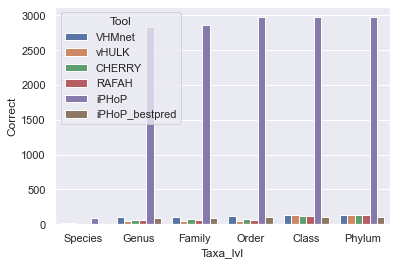

In [90]:
sns.set(rc={'figure.figsize':(15,10)})
g = sns.barplot(data=results,
                x='Taxa_lvl', y='Correct', hue='Tool',
                ci = None)

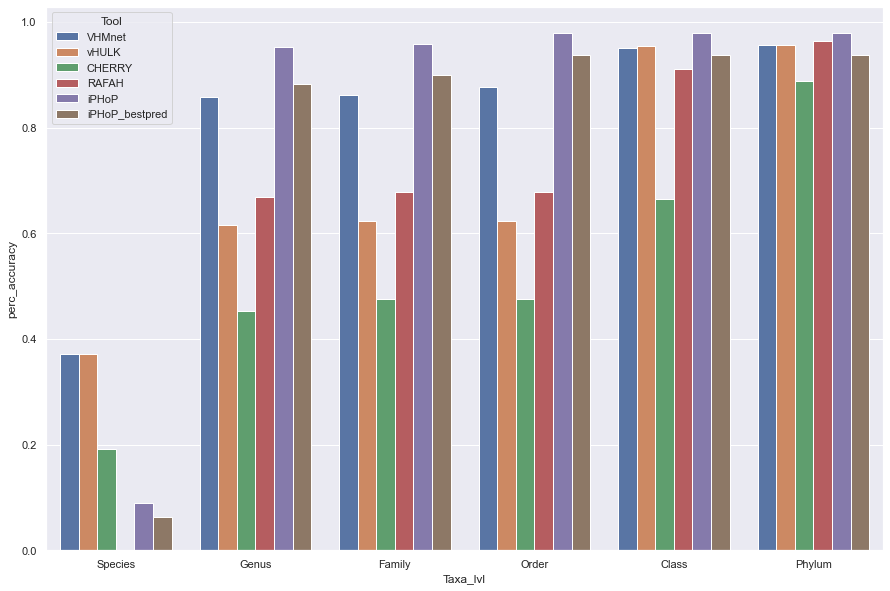

In [91]:
sns.set(rc={'figure.figsize':(15,10)})
g = sns.barplot(data=results,
                x='Taxa_lvl', y='perc_accuracy', hue='Tool',
                ci = None)

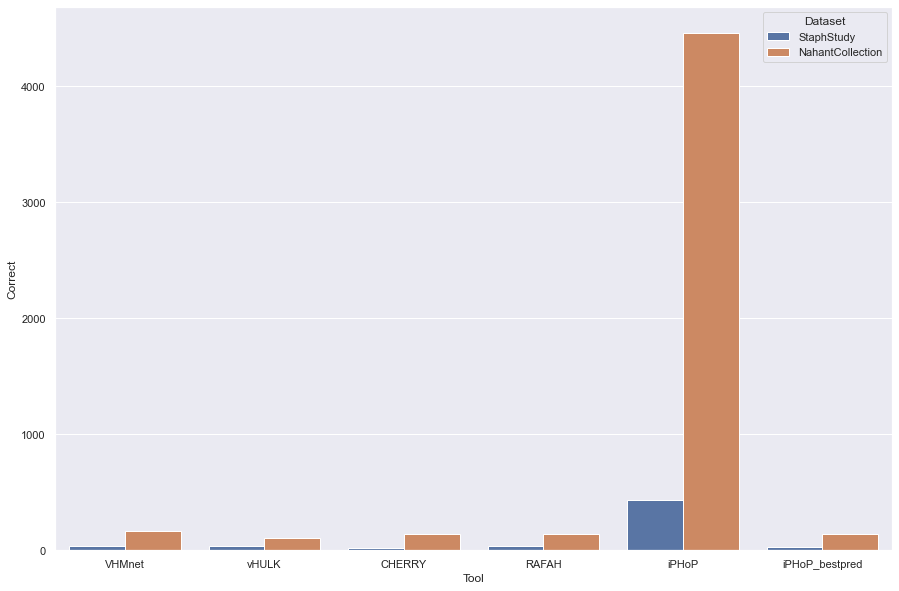

In [92]:
sns.set(rc={'figure.figsize':(15,10)})
g = sns.barplot(data=results,
                x='Tool', y='Correct', hue='Dataset',
                ci = None)

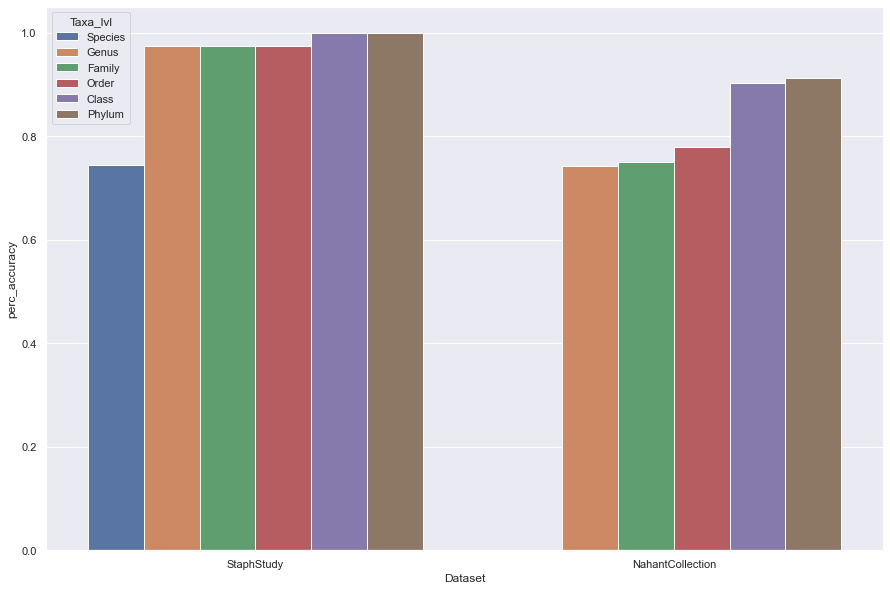

In [93]:
sns.set(rc={'figure.figsize':(15,10)})
g = sns.barplot(data=results[results['Tool'] == 'VHMnet'],
                x='Dataset', y='perc_accuracy', hue='Taxa_lvl',
                ci = None)